## Github URL

---
https://github.com/Arravee/NLP_Disaster

## Get the Data

We will be using the terminal commands below to downlaod the data directly. Please note that to use the Kaggle API with this method, we must first downlaod our kaggle.json file which can be found under the API section of our Kaggle profile.

In [ ]:
#! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download nlp-getting-started



  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 114MB/s]


In [ ]:
! unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Problem and Dataset Description

The dataset we will be analyzing is the NLP-Getting_started dataset from Kaggle. The dataset contains over 10,000 tweets. We will be using NLP techniques to identify keywords, patterns, and the nature of the respective tweet. This dataset can be found here: https://www.kaggle.com/competitions/nlp-getting-started/overview. Directly below are all the modules we will be using in our program.

In [ ]:
import numpy as np
import pandas as pd
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
import string
from keras.preprocessing.text import Tokenizer

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import nltk
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers import (LSTM, 
                          Activation,
                          Conv1D,
                          MaxPooling1D,
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)

from keras import regularizers, optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split


## EDA

In [ ]:
#Import the Dataset and get a general initial look at it
train_df = pd.read_csv('train.csv', dtype=str)
print(train_df.shape)
train_df.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
#Now let's look at value counts. This is important because we have worked with heavily skewed data berfore and
#if there a low amount of positive/negative samples we will need to adjust the ratio before plugging the data into 
#our future models.

train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

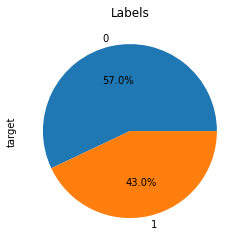

In [ ]:
train_df['target'].value_counts().plot(kind='pie',grid=True,title='Labels', autopct='%1.1f%%')

The proportion of positive to negative cases is perfectly fine but in our initial look at the data we notice Nan values for keyword and location. Let's take a closer look at that.

In [ ]:
train_df['location'].value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [ ]:
train_df['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

We had initially taken out the Nan values, however, as our code simply looks at the content of the text column this is unnecessary. However, if we wish to use multiple linear regression or other multi-factor algorithms on a future follow-up, we can uncomment the code below. 

In [ ]:
train_cut = train_df.copy()#dropna().reset_index().drop(labels = 'index', axis = 1)
train_cut

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


Uncomment cell below along with above to see the change in distribution if we were to remove rows with Nan values.

In [1]:
#train_cut['target'].value_counts().plot(kind='pie',grid=True,title='Labels', autopct='%1.1f%%')

From here we will look at plots for both keywords and location. We will also look at the length of the tweets that are left. This is a nice and straightforward way to look at the spread of our data.

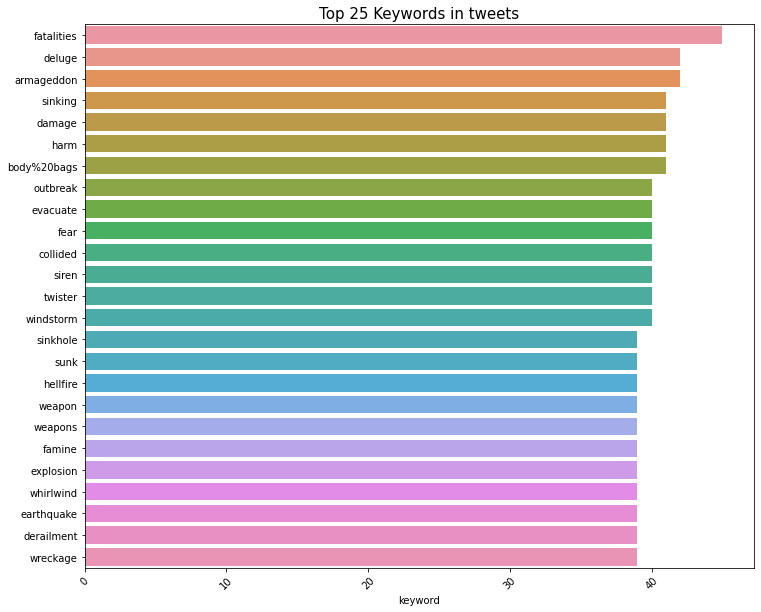

In [ ]:
fig,axes = plt.subplots(figsize=(12,10))

top_keywords=train_cut['keyword'].value_counts()[:25]
ax = sns.barplot(y=top_keywords.index,x=top_keywords, data=train_cut)
plt.title('Top 25 Keywords in tweets',fontsize=15)
plt.xticks(rotation=45)
plt.show()

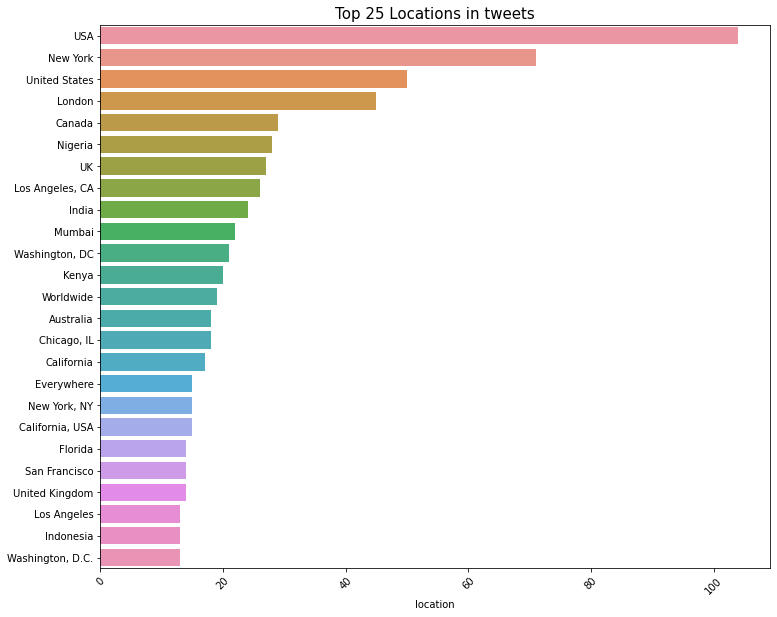

In [ ]:
fig,axes = plt.subplots(figsize=(12,10))

top_locations=train_cut['location'].value_counts()[:25]
ax = sns.barplot(y=top_locations.index,x=top_locations,data=train_cut)
plt.title('Top 25 Locations in tweets',fontsize=15)
plt.xticks(rotation=45)
plt.show()

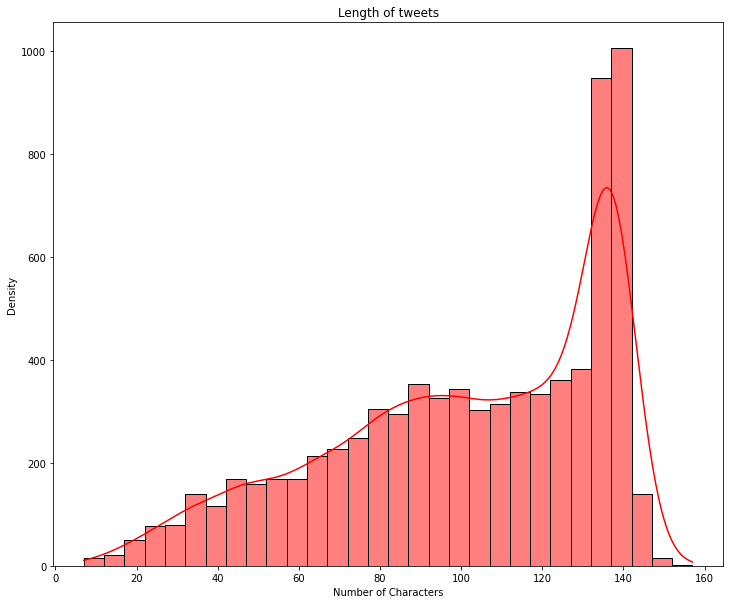

In [ ]:
train_cut['length']  = train_cut["text"].apply(len)

plt.figure(figsize=(12,10))

sns.histplot(train_cut['length'], kde=True,color='red',bins=30)
plt.title("Length of tweets")
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.show()

## Preprocessing
Now that we have taken a visual look at our data we can start pre-processing. While it is possible to move straight to the model, that is not efficient. Language is filled with words that either don't add enough meaning to the context of a tweet or can be simplified into a more lemmatized form. 

This code is derived from a networks analytics project and slightly modified for the purpose reading these tweets. Explanations of all the code is in commented form.

In [ ]:
TWEET_TOKENIZER = nltk.TweetTokenizer().tokenize
WORD_TOKENIZER = nltk.tokenize.word_tokenize

def tokenize(text, lowercase=True, tweet=False):
    """Tokenize the text. By default, also normalizes text to lowercase.
    Optionally uses the Tweet Tokenizer.
    """
    if lowercase:
        text = text.lower()
    if tweet:
        return TWEET_TOKENIZER(text)
    else:
        return WORD_TOKENIZER(text)

In [ ]:
test_tweet = tokenize(text = train_cut['text'][0], tweet = True)
print(test_tweet)

['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#earthquake', 'may', 'allah', 'forgive', 'us', 'all']


In [ ]:
STEMMER = nltk.PorterStemmer()

def stem(tokens):
    """Stem the tokens. I.e., remove morphological affixes and
    normalize to standardized stem forms.

    Has the side effective of producing "unnatural" forms due to
    stemming standards. E.g. quickly becomes quickli
    """
    return [ STEMMER.stem(token) for token in tokens ]

In [ ]:
stem(test_tweet)


['our',
 'deed',
 'are',
 'the',
 'reason',
 'of',
 'thi',
 '#earthquak',
 'may',
 'allah',
 'forgiv',
 'us',
 'all']

In [ ]:
LEMMATIZER = nltk.WordNetLemmatizer()

def lemmatize(tokens):
    """Lemmatize the tokens.
    
    Retains more natural word forms than stemming, but assumes all
    tokens are nouns unless tokens are passed as (word, pos) tuples.
    """
    lemmas = []
    for token in tokens:
        if isinstance(token, str):
            lemmas.append(LEMMATIZER.lemmatize(token)) # treats token like a noun
        else: # assume a tuple of (word, pos)
            lemmas.append(LEMMATIZER.lemmatize(*token))
    return lemmas
    

In [ ]:
lemmatize(test_tweet)

['@bbcmtd', 'wholesale', 'market', 'ablaze', 'http://t.co/lhyxeohy6c']

In [ ]:
def remove_stopwords(tokens, stopwords=None):
    """Remove stopwords, i.e. words that we don't want as part of our
    analysis. Defaults to the default set of nltk english stopwords.
    """
    if stopwords is None:
        stopwords = nltk.corpus.stopwords.words("english")
    return [ token for token in tokens if token not in stopwords ]

In [ ]:
remove_stopwords(test_tweet)

['@bbcmtd', 'wholesale', 'markets', 'ablaze', 'http://t.co/lhyxeohy6c']

In [ ]:
def remove_links(tokens):
    """Removes http/s links from the tokens.

    This simple implementation assumes links have been kept intact as whole
    tokens. E.g. the way the Tweet Tokenizer works.
    """
    return [ t for t in tokens
            if not t.startswith("http://")
            and not t.startswith("https://")
        ]


In [ ]:
remove_links(test_tweet)

['@bbcmtd', 'wholesale', 'markets', 'ablaze']

In [ ]:
def remove_punctuation(tokens,
                       strip_mentions=False,
                       strip_hashtags=False,
                       strict=False):
    """Remove punctuation from a list of tokens.

    Has some specialized options for dealing with Tweets:

    strip_mentions=True will strip the @ off of @ mentions
    strip_hashtags=True will strip the # from hashtags

    strict=True will remove all punctuation from all tokens, not merely
    just tokens that are punctuation per se. 
    """
    tokens = [t for t in tokens if t not in string.punctuation]
    if strip_mentions:
        tokens = [t.lstrip('@') for t in tokens]
    if strip_hashtags:
        tokens = [t.lstrip('#') for t in tokens]
    if strict:
        cleaned = []
        for t in tokens:
            cleaned.append(
                t.translate(str.maketrans('', '', string.punctuation)).strip())
        tokens = [t for t in cleaned if t]
    return tokens

In [ ]:
train_preprocess = train_cut.copy()

In [ ]:
for i in range(len(train_preprocess)): 
  text = train_preprocess['text'][i]
  tokens = tokenize(text, tweet=True)
  tokens = remove_links(tokens)
  tokens = remove_stopwords(tokens)
  tokens = remove_punctuation(tokens, strip_mentions=True, strip_hashtags=True)
  tokens = lemmatize(tokens) 
  train_preprocess['text'][i] = ' '.join(tokens)



In [ ]:
train_preprocess

,id,keyword,location,text,target,length
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1,69
1,4,NaN,NaN,forest fire near la ronge sask canada,1,38
2,5,NaN,NaN,resident asked shelter place notified officer ...,1,133
3,6,NaN,NaN,"13,000 people receive wildfire evacuation orde...",1,65
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1,88
...,...,...,...,...,...,...
7608,10869,NaN,NaN,two giant crane holding bridge collapse nearby...,1,83
7609,10870,NaN,NaN,aria_ahrary thetawniest control wild fire cali...,1,125
7610,10871,NaN,NaN,m1 94 01:04 utc 5km volcano hawaii,1,65
7611,10872,NaN,NaN,police investigating e-bike collided car littl...,1,137


Now that we have a more "straightforward" tweet to work with we can represent it as a vector. This is needed to use the LStM model architecture. 

In [ ]:
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train_preprocess['text'].values)
X = tokenizer.texts_to_sequences(train_preprocess['text'].values)
X = pad_sequences(X)

In [ ]:
y = train_preprocess['target']

In [ ]:
X

array([[   0,    0,    0, ...,   72, 1476,    5],
       [   0,    0,    0, ...,  165,  604, 1286],
       [   0,    0,    0, ...,  491,  344, 1009],
       ...,
       [   0,    0,    0, ..., 1464,  466, 1465],
       [   0,    0,    0, ...,   27, 1897,   79],
       [   0,    0,    0, ...,   87,  615,   12]], dtype=int32)

In [ ]:
type(X)

numpy.ndarray

VERY IMPORTANT!
You must convert the y variable to integers/floats. If you leave as is, tensorflow will through a graph execution error.

In [ ]:
y = np.array(y)
y = y.astype(int)
y

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
X.shape, y.shape

((7613, 24), (7613,))

## Model Architecture

We will use a train test split to get training and validation data and move on to our model. We will create architectures based on LSTM, a popular model for classifying text. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state =42)

In [ ]:
X_train.shape, y_train.shape

((5329, 24), (5329,))

In [ ]:
# embed_dim = 32
# #lstm_out = 32

# model_1 = Sequential()

# model_1.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
# model_1.add(Dropout(0.2))
# model_1.add(LSTM(32))
# model_1.add(Dropout(0.2))
# model_1.add(Dense(1,activation='sigmoid'))


# adam = tf.keras.optimizers.Adam(learning_rate=0.002)
# model_1.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])

# print(model_1.summary())

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
# embed_dim = 32
# lstm_out = 32

model = Sequential()

model.add(Embedding(max_features, 32))
model.add(Dropout(0.2))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.4))
model.add(Dense(1,activation='sigmoid'))

adam = tf.keras.optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, None, 32)          96000     
                                                                 
 dropout_33 (Dropout)        (None, None, 32)          0         
                                                                 
 lstm_48 (LSTM)              (None, 200)               186400    
                                                                 
 dense_31 (Dense)            (None, 1)                 201       
                                                                 
Total params: 282,601
Trainable params: 282,601
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
LSTM_1 = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=64, callbacks = [callbacks])

Epoch 1/20
84/84 [==============================] - 14s 132ms/step - loss: 0.5687 - accuracy: 0.7056 - val_loss: 0.4405 - val_accuracy: 0.8017 - lr: 0.0020
Epoch 2/20
84/84 [==============================] - 11s 129ms/step - loss: 0.3707 - accuracy: 0.8422 - val_loss: 0.4678 - val_accuracy: 0.7938 - lr: 0.0020
Epoch 3/20
84/84 [==============================] - 11s 130ms/step - loss: 0.3067 - accuracy: 0.8746 - val_loss: 0.4929 - val_accuracy: 0.7982 - lr: 0.0020
Epoch 4/20
84/84 [==============================] - 11s 129ms/step - loss: 0.2704 - accuracy: 0.8889 - val_loss: 0.5599 - val_accuracy: 0.7535 - lr: 0.0020
Epoch 5/20
84/84 [==============================] - 11s 129ms/step - loss: 0.2476 - accuracy: 0.9019 - val_loss: 0.5781 - val_accuracy: 0.7715 - lr: 0.0020
Epoch 6/20
84/84 [==============================] - 11s 129ms/step - loss: 0.2208 - accuracy: 0.9135 - val_loss: 0.6659 - val_accuracy: 0.7623 - lr: 0.0020


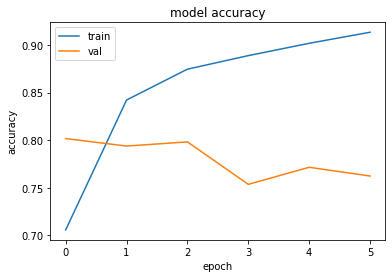

In [ ]:
plt.plot(LSTM_1.history['accuracy'])
plt.plot(LSTM_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model_2 = Sequential()

model_2.add(Embedding(max_features, 32))
model_2.add(Dropout(0.2))
model_2.add(LSTM(200, dropout=0.2, return_sequences = True, recurrent_dropout=0.4))
model_2.add(LSTM(200, dropout=0.2, return_sequences = True, recurrent_dropout=0.4))
model_2.add(LSTM(200, dropout=0.2, recurrent_dropout=0.4))
model_2.add(Dense(1,activation='sigmoid'))

adam = tf.keras.optimizers.Adam(learning_rate=0.002)
model_2.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model_2.summary())

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, None, 32)          96000     
                                                                 
 dropout_34 (Dropout)        (None, None, 32)          0         
                                                                 
 lstm_49 (LSTM)              (None, None, 200)         186400    
                                                                 
 lstm_50 (LSTM)              (None, None, 200)         320800    
                                                                 
 lstm_51 (LSTM)              (None, 200)               320800    
                                                                 
 dense_32 (Dense)            (None, 1)                 201       
                                                                 
Total params: 924,201
Trainable params: 924,201
Non-t

In [ ]:
LSTM_2 = model_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64, callbacks = [callbacks])

Epoch 1/20
84/84 [==============================] - 40s 380ms/step - loss: 0.5689 - accuracy: 0.7003 - val_loss: 0.4679 - val_accuracy: 0.7846 - lr: 0.0020
Epoch 2/20
84/84 [==============================] - 31s 369ms/step - loss: 0.3827 - accuracy: 0.8371 - val_loss: 0.4708 - val_accuracy: 0.7890 - lr: 0.0020
Epoch 3/20
84/84 [==============================] - 31s 374ms/step - loss: 0.3191 - accuracy: 0.8718 - val_loss: 0.4733 - val_accuracy: 0.7903 - lr: 0.0020
Epoch 4/20
84/84 [==============================] - 31s 369ms/step - loss: 0.2757 - accuracy: 0.8915 - val_loss: 0.5073 - val_accuracy: 0.7723 - lr: 0.0020
Epoch 5/20
84/84 [==============================] - 31s 367ms/step - loss: 0.2520 - accuracy: 0.9092 - val_loss: 0.5491 - val_accuracy: 0.7728 - lr: 0.0020
Epoch 6/20
84/84 [==============================] - 31s 367ms/step - loss: 0.2382 - accuracy: 0.9109 - val_loss: 0.5734 - val_accuracy: 0.7706 - lr: 0.0020
Epoch 7/20
84/84 [==============================] - 31s 373ms/st

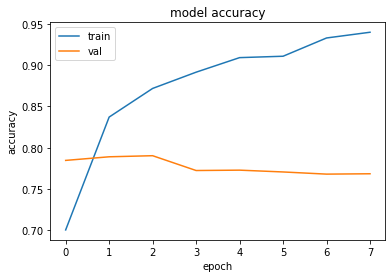

In [ ]:
plt.plot(LSTM_2.history['accuracy'])
plt.plot(LSTM_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model_3 = Sequential()

model_3.add(Embedding(max_features, 32))

model_3.add(Bidirectional(LSTM(200, return_sequences = True, recurrent_dropout=0.2)))

model_3.add(GlobalMaxPool1D())
model_3.add(BatchNormalization())
model_3.add(Dropout(0.5))
model_3.add(Dense(200, activation = "relu"))
model_3.add(Dropout(0.5))
model_3.add(Dense(200, activation = "relu"))
model_3.add(Dropout(0.5))
model_3.add(Dense(1, activation = 'sigmoid'))


model_3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
print(model_3.summary())

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, None, 32)          96000     
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 400)        372800    
 nal)                                                            
                                                                 
 global_max_pooling1d_2 (Glo  (None, 400)              0         
 balMaxPooling1D)                                                
                                                                 
 batch_normalization_2 (Batc  (None, 400)              1600      
 hNormalization)                                                 
                                                                 
 dropout_35 (Dropout)        (None, 400)               0         
                                                     

In [ ]:
LSTM_3 = model_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, callbacks = [callbacks])

Epoch 1/20
167/167 [==============================] - 40s 208ms/step - loss: 0.5654 - accuracy: 0.7029 - val_loss: 0.6346 - val_accuracy: 0.7040 - lr: 0.0010
Epoch 2/20
167/167 [==============================] - 34s 202ms/step - loss: 0.4306 - accuracy: 0.8182 - val_loss: 0.5820 - val_accuracy: 0.7968 - lr: 0.0010
Epoch 3/20
167/167 [==============================] - 34s 201ms/step - loss: 0.3789 - accuracy: 0.8441 - val_loss: 0.4831 - val_accuracy: 0.7833 - lr: 0.0010
Epoch 4/20
167/167 [==============================] - 34s 203ms/step - loss: 0.3664 - accuracy: 0.8527 - val_loss: 0.4785 - val_accuracy: 0.7736 - lr: 0.0010
Epoch 5/20
167/167 [==============================] - 33s 200ms/step - loss: 0.3299 - accuracy: 0.8677 - val_loss: 0.5148 - val_accuracy: 0.8082 - lr: 0.0010
Epoch 6/20
167/167 [==============================] - 33s 200ms/step - loss: 0.3112 - accuracy: 0.8820 - val_loss: 0.8004 - val_accuracy: 0.7631 - lr: 0.0010
Epoch 7/20
167/167 [==============================] 

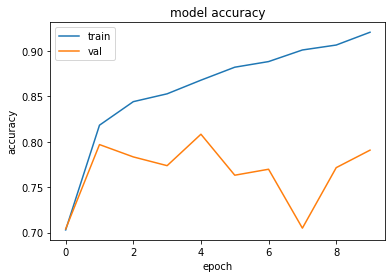

In [ ]:
plt.plot(LSTM_3.history['accuracy'])
plt.plot(LSTM_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Conclusion 
There are a few areas of improvement. The most obvious is adding more layers to the model. The more layers we add the longer the runtime to initialize the said model. We will encounter the same performance issues if we increase the number of epochs, perhaps to 30, and get rid of the callback which stops the function early based on parameters such as val_loss. This performance hit isn't terrible as we ran this using Google Colab Pro but if you were to run this without a GPU each epoch could take 20-50 minutes. 

However, even if we add more layers the improvement is minimal. Our training accuracy was the highest with our second model at .94 but our validation accuracy was increasing with our third model. We redid our third model multiple times and went from a test score of .52 to .57. Looking at other people's projects it seems that a big area for improvement is the embedding layer and we will take a closer look at that in future iterations of the project.
 
Finally, we could try other types of models such as Bert and GRU, which other people have had some success with. 

Overall, our best model performance on the test set was poor and we believe it to be a problem with overfitting. Hopefully, as we continue onwards we can construct a model that is not only accurate with our training data but our test data as well. 



In [ ]:
test_df = pd.read_csv('test.csv', dtype=str)
print(test_df.shape)
test_df.head()

(3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
for i in range(len(test_df)): 
  text = test_df['text'][i]
  tokens = tokenize(text, tweet=True)
  tokens = remove_links(tokens)
  tokens = remove_stopwords(tokens)
  tokens = remove_punctuation(tokens, strip_mentions=True, strip_hashtags=True)
  tokens = lemmatize(tokens) 
  test_df['text'][i] = ' '.join(tokens)

In [ ]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different city stay safe ever...
2,3,NaN,NaN,forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfire
4,11,NaN,NaN,typhoon soudelor kill 28 china taiwan
...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles  ûò safety fast...
3259,10865,NaN,NaN,storm ri worse last hurricane city 3others har...
3260,10868,NaN,NaN,green line derailment chicago
3261,10874,NaN,NaN,meg issue hazardous weather outlook hwo


In [ ]:
max_features = 3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(test_df['text'].values)
test_x = tokenizer.texts_to_sequences(test_df['text'].values)
test_x = pad_sequences(test_x)

In [ ]:
test_predict = model_3.predict(test_x)
test_predict = test_predict.round()

In [ ]:
submission = test_df.copy()
submission['target']= test_predict.astype(int)
submission = submission.drop(labels = ['keyword', 'location', 'text'], axis = 1)
submission.head()


,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,0


In [ ]:
submission.to_csv('nlp_disaster_submission_new.csv',index=False)